In [1]:
!pip install -U albumentations>=0.3.0 --user 
!pip install -U --pre segmentation-models --user

Requirement already up-to-date: segmentation-models in /home/pratik/.local/lib/python3.7/site-packages (1.0.1)


In [2]:
root_dir = '/home/pratik/coding/MTech_Project'

In [3]:
import os

In [4]:
x_train_dir = os.path.join(root_dir, 'data', 'train')
y_train_dir = os.path.join(root_dir, 'data', 'train_annot')

x_valid_dir = os.path.join(root_dir, 'data', 'val')
y_valid_dir = os.path.join(root_dir, 'data', 'val_annot')

x_test_dir = os.path.join(root_dir, 'data', 'test')
y_test_dir = os.path.join(root_dir, 'data', 'test_annot')

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [6]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        #print(self.masks_fps)
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls) for cls in classes]
        
        #print(self.class_values)
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        #print(mask)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == (v*2)+3) for v in self.class_values]
        #for v in self.class_values:
        #print(v)
        #print(masks)
        mask = np.stack(masks, axis=-1).astype('float')
        #print(mask)
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

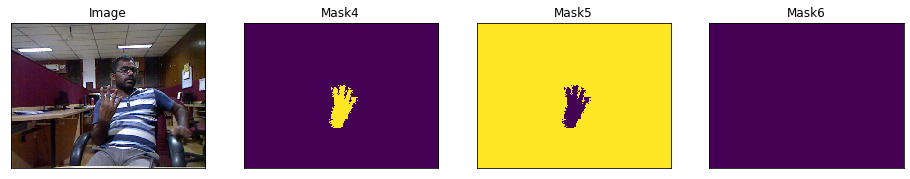

In [7]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])
image, mask = dataset[0] # get some sample
visualize(
    image=image, 
    mask4 = mask[..., 4].squeeze(),
    mask5 = mask[..., 36].squeeze(),
    mask6 = mask[..., 5].squeeze()
)

In [8]:
# Training

In [9]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [10]:
BACKBONE = 'resnet101'
BATCH_SIZE = 2
CLASSES = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

In [11]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [12]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
#dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
#total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, focal_loss, metrics)

In [13]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)
print(len(train_dataloader))
print(len(valid_dataloader))
print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)
# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 480, 640, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 480, 640, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model1.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

14814
7427
(2, 480, 640, 3)
(2, 480, 640, 37)


In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)


Epoch 1/40
14814/14814 [==============================] - 6955s 470ms/step - loss: 4.8163e-04 - iou_score: 0.9458 - f1-score: 0.9477 - val_loss: 9.1053e-05 - val_iou_score: 0.9629 - val_f1-score: 0.9654
Epoch 2/40
14814/14814 [==============================] - 6931s 468ms/step - loss: 5.9596e-05 - iou_score: 0.9637 - f1-score: 0.9683 - val_loss: 5.3824e-05 - val_iou_score: 0.9764 - val_f1-score: 0.9790
Epoch 3/40
14814/14814 [==============================] - 6937s 468ms/step - loss: 3.5230e-05 - iou_score: 0.9816 - f1-score: 0.9861 - val_loss: 2.8008e-05 - val_iou_score: 0.9799 - val_f1-score: 0.9824
Epoch 4/40
14814/14814 [==============================] - 6939s 468ms/step - loss: 2.5964e-05 - iou_score: 0.9882 - f1-score: 0.9925 - val_loss: 1.6817e-05 - val_iou_score: 0.9812 - val_f1-score: 0.9835
Epoch 5/40
14814/14814 [==============================] - 6953s 469ms/step - loss: 2.1466e-05 - iou_score: 0.9898 - f1-score: 0.9939 - val_loss: 1.4583e-05 - val_iou_score: 0.9821 - val_f

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



14814/14814 [==============================] - 6956s 470ms/step - loss: 1.9597e-05 - iou_score: 0.9905 - f1-score: 0.9945 - val_loss: 1.3297e-05 - val_iou_score: 0.9845 - val_f1-score: 0.9869
Epoch 7/40
14814/14814 [==============================] - 6983s 471ms/step - loss: 1.8281e-05 - iou_score: 0.9908 - f1-score: 0.9947 - val_loss: 4.5213e-04 - val_iou_score: 0.9833 - val_f1-score: 0.9856
Epoch 8/40
14814/14814 [==============================] - 6987s 472ms/step - loss: 1.7571e-05 - iou_score: 0.9911 - f1-score: 0.9949 - val_loss: 1.6822e-05 - val_iou_score: 0.9833 - val_f1-score: 0.9857
Epoch 9/40
14814/14814 [==============================] - 6990s 472ms/step - loss: 1.6564e-05 - iou_score: 0.9914 - f1-score: 0.9952 - val_loss: 1.6753e-05 - val_iou_score: 0.9854 - val_f1-score: 0.9876
Epoch 10/40
14814/14814 [==============================] - 6979s 471ms/step - loss: 1.5796e-05 - iou_score: 0.9916 - f1-score: 0.9954 - val_loss: 2.2831e-05 - val_iou_score: 0.9842 - val_f1-score: 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



14814/14814 [==============================] - 6992s 472ms/step - loss: 1.4632e-05 - iou_score: 0.9919 - f1-score: 0.9956 - val_loss: 1.8159e-05 - val_iou_score: 0.9847 - val_f1-score: 0.9870
Epoch 13/40
14814/14814 [==============================] - 7001s 473ms/step - loss: 1.4507e-05 - iou_score: 0.9919 - f1-score: 0.9956 - val_loss: 1.6559e-05 - val_iou_score: 0.9847 - val_f1-score: 0.9870
Epoch 14/40
14814/14814 [==============================] - 7009s 473ms/step - loss: 1.4429e-05 - iou_score: 0.9920 - f1-score: 0.9956 - val_loss: 1.7036e-05 - val_iou_score: 0.9847 - val_f1-score: 0.9870
Epoch 15/40
14814/14814 [==============================] - 7003s 473ms/step - loss: 1.4366e-05 - iou_score: 0.9920 - f1-score: 0.9956 - val_loss: 1.7794e-05 - val_iou_score: 0.9847 - val_f1-score: 0.9869
Epoch 16/40
14814/14814 [==============================] - 6991s 472ms/step - loss: 1.4310e-05 - iou_score: 0.9920 - f1-score: 0.9956 - val_loss: 1.7821e-05 - val_iou_score: 0.9846 - val_f1-score:

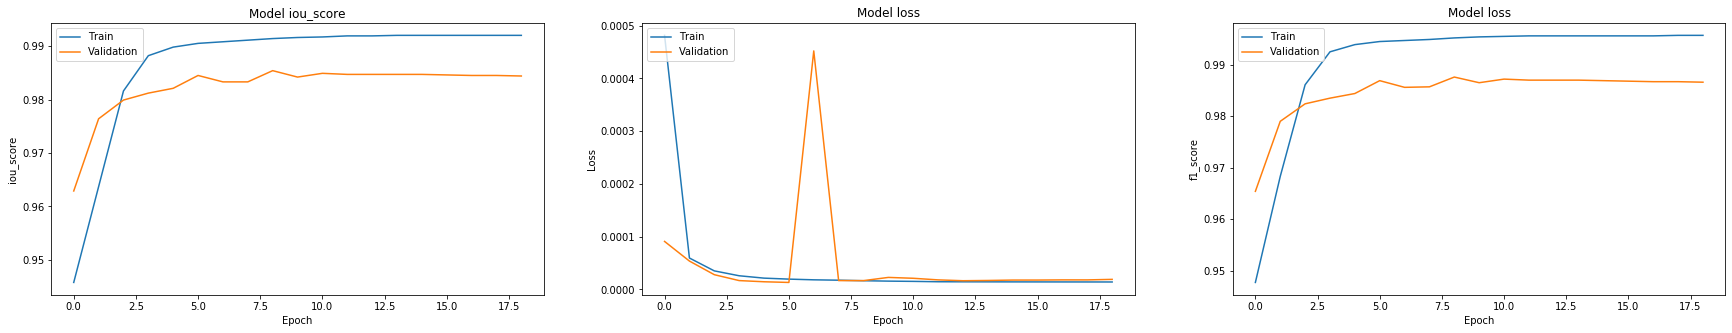

In [16]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(131)
plt.plot([0.9458, 0.9637, 0.9816, 0.9882, 0.9898, 0.9905, 0.9908, 0.9911, 0.9914, 0.9916, 0.9917, 0.9919, 0.9919, 0.9920, 0.9920, 0.9920, 0.9920, 0.9920, 0.9920])
plt.plot([0.9629, 0.9764, 0.9799, 0.9812, 0.9821, 0.9845, 0.9833, 0.9833, 0.9854, 0.9842, 0.9849, 0.9847, 0.9847, 0.9847, 0.9847, 0.9846, 0.9845, 0.9845, 0.9844])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(132)
plt.plot([4.8163e-04, 5.9596e-05, 3.5230e-05, 2.5964e-05, 2.1466e-05, 1.9597e-05, 1.8281e-05, 1.7571e-05, 1.6564e-05, 1.5796e-05, 1.5325e-05, 1.4632e-05, 1.4507e-05, 1.4429e-05, 1.4366e-05, 1.4310e-05, 1.4268e-05, 1.4225e-05, 1.4185e-05])
plt.plot([9.1053e-05, 5.3824e-05, 2.8008e-05, 1.6817e-05, 1.4583e-05, 1.3297e-05, 4.5213e-04, 1.6822e-05, 1.6753e-05, 2.2831e-05, 2.1196e-05, 1.8159e-05, 1.6559e-05, 1.7036e-05, 1.7794e-05, 1.7821e-05, 1.8149e-05, 1.8114e-05, 1.9141e-05])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation f1_score values
plt.subplot(133)
plt.plot([0.9477, 0.9683, 0.9861, 0.9925, 0.9939, 0.9945, 0.9947, 0.9949, 0.9952, 0.9954, 0.9955, 0.9956, 0.9956, 0.9956, 0.9956, 0.9956, 0.9956, 0.9957, 0.9957])
plt.plot([0.9654, 0.9790, 0.9824, 0.9835, 0.9844, 0.9869, 0.9856, 0.9857, 0.9876, 0.9865, 0.9872, 0.9870, 0.9870, 0.9870, 0.9869, 0.9868, 0.9867, 0.9867, 0.9866])
plt.title('Model loss')
plt.ylabel('f1_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()